# Apply LSTM to predict price and sales and look for possible connections


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 导入数据

In [2]:
data_frame = pd.read_csv('../tables/20w_with_harbor_pair.csv')
data_frame_deal = pd.read_csv('../tables/40w_with_harbor_pair.csv')

## 创建单个港口每日销量表
选择出现最多的营口-宁波航线

In [3]:
target_begin = data_frame[data_frame['PORT_BEGIN'] == '营口']
target_end = target_begin[target_begin['PORT_END'] == '宁波']
dates = target_end.groupby(target_end['WBL_AUD_DT']).size()
date_csv = pd.DataFrame(dates)

#40w有合约
target_begin_deal = data_frame_deal[data_frame_deal['PORT_BEGIN'] == '营口']
target_end_deal= target_begin_deal[target_begin_deal['PORT_END'] == '宁波']
dates_deal = target_end_deal.groupby(target_end_deal['WBL_AUD_DT']).size()
date_csv_deal = pd.DataFrame(dates_deal)

## 数据预处理

In [4]:
# 数据预处理
date_csv = date_csv.dropna()
dataset = date_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)  # 获得最大值
min_value = np.min(dataset)  # 获得最小值
scalar = max_value - min_value  # 获得间隔数量
dataset = list(map(lambda x: x / scalar, dataset)) # 归一化

#40w有合约
date_csv_deal = date_csv_deal.dropna()
dataset_deal = date_csv_deal.values
dataset_deal = dataset_deal.astype('float32')
max_value_deal = np.max(dataset_deal)  # 获得最大值
min_value_deal = np.min(dataset_deal)  # 获得最小值
scalar_deal = max_value_deal - min_value_deal  # 获得间隔数量
dataset_deal = list(map(lambda x: x / scalar_deal, dataset_deal)) # 归一化

## 设置数据集
设置X,Y数据集。以look_back=2为准，取第一个和第二个为数组，形成data_X,取第三个作为预测值，形成data_Y，完成训练集的提取。

In [5]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)
#40w有合约
data_X_deal, data_Y_deal = create_dataset(dataset_deal)

## 设置训练集和测试集

In [6]:
# 划分训练集和测试集，70% 作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

#40w有合约
train_size_deal = int(len(data_X_deal) * 0.7)
test_size_deal = len(data_X_deal) - train_size_deal
train_X_deal = data_X_deal[:train_size_deal]
train_Y_deal = data_Y_deal[:train_size_deal]
test_X_deal = data_X_deal[train_size_deal:]
test_Y_deal = data_Y_deal[train_size_deal:]

## 设置LSTM模型数据类型形状
设置LSTM能识别的数据类型，形成train_X的一维两个参数的数组，train_Y的一维一个参数的数组。并转化为tensor类型

In [7]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

#40w有合约
train_X_deal = train_X_deal.reshape(-1, 1, 2)
train_Y_deal = train_Y_deal.reshape(-1, 1, 1)
test_X_deal = test_X_deal.reshape(-1, 1, 2)

train_x_deal = torch.from_numpy(train_X_deal)
train_y_deal = torch.from_numpy(train_Y_deal)
test_x_deal = torch.from_numpy(test_X_deal)

## 建立LSTM模型
建立LSTM模型，第一层为LSTM神经网络，第二层为一个全连接层。

In [8]:
from torch import nn
from torch.autograd import Variable

class lstm(nn.Module):
    def __init__(self,input_size=2,hidden_size=4,output_size=1,num_layer=2,):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        s,b,h = x.size()
        x = x.view(s*b,h)
        x = self.layer2(x)
        x = x.view(s,b,-1)
        return x

model = lstm(2,4,1,2)
#40w有合约
model_deal = lstm(2,4,1,2)

## 建立损失函数和优化器
设置交叉熵损失函数和自适应梯度下降算法

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

criterion_deal = nn.MSELoss()
optimizer_deal = torch.optim.Adam(model_deal.parameters(), lr=1e-2)

## 模型训练

In [10]:
# 开始训练
for e in range(10000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 1000 == 0: # 每 100 次输出结果
        print(f"Epoch: {e + 1}, Loss: {loss.item()}")

#40w有合约
for e in range(10000):
    var_x_deal = Variable(train_x_deal)
    var_y_deal = Variable(train_y_deal)
    # 前向传播
    out_deal = model_deal(var_x_deal)
    loss_deal = criterion_deal(out_deal, var_y_deal)
    # 反向传播
    optimizer_deal.zero_grad()
    loss_deal.backward()
    optimizer_deal.step()
    
    if (e + 1) % 1000 == 0: # 每 100 次输出结果
        print(f"Epoch: {e + 1}, Loss: {loss_deal.item()}")

Epoch: 100, Loss: 0.011874878779053688


KeyboardInterrupt: 

## 模型预测

In [11]:
model = model.eval() # 转换成测试模式

data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = model(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()

#40w有合约
model_deal = model_deal.eval() # 转换成测试模式

data_X_deal = data_X_deal.reshape(-1, 1, 2)
data_X_deal = torch.from_numpy(data_X_deal)
var_data_deal = Variable(data_X_deal)
pred_test_deal = model_deal(var_data_deal) # 测试集的预测结果
# 改变输出的格式
pred_test_deal = pred_test_deal.view(-1).data.numpy()

## 预测序列可视化

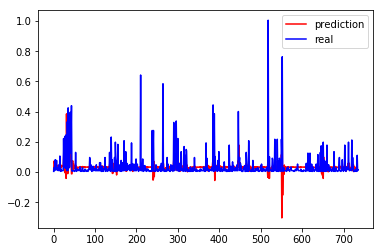

In [12]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

#40w有合约
plt.plot(pred_test_deal, 'r', label='prediction')
plt.plot(dataset_deal, 'b', label='real')
plt.legend(loc='best')